In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import sys

## 1. Image Segmentation Using Thresholding

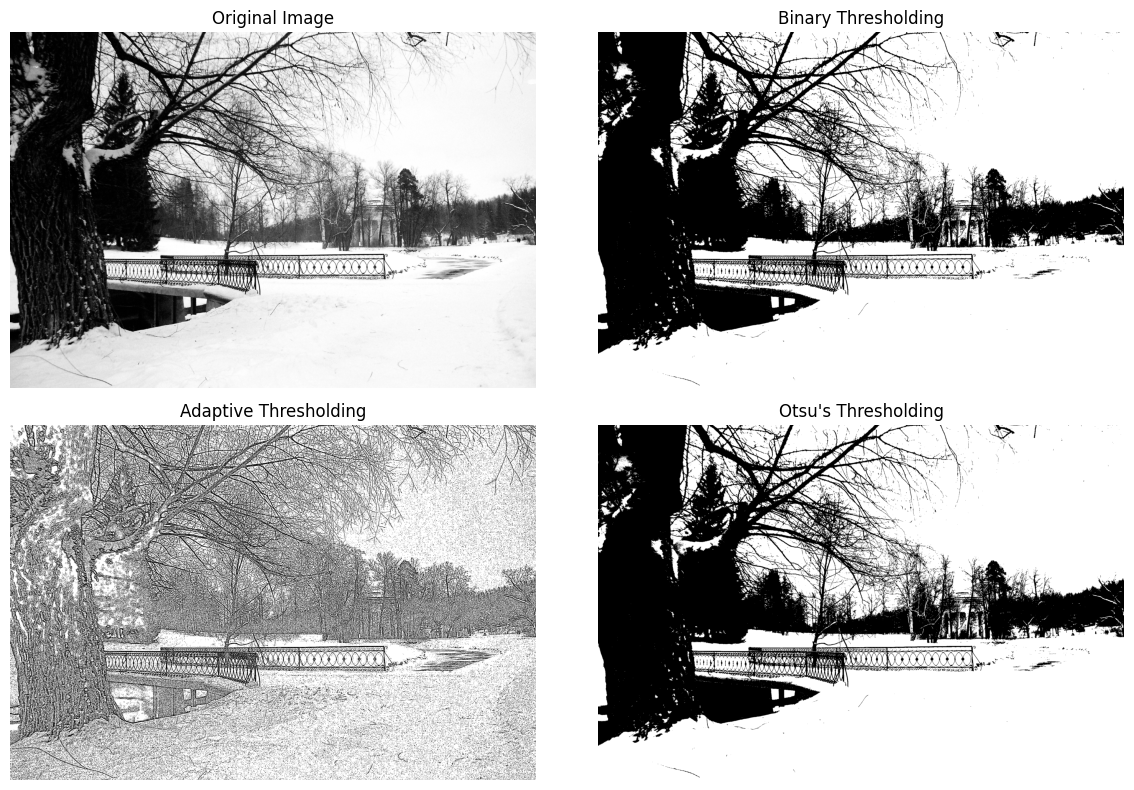

In [7]:
import cv2
import matplotlib.pyplot as plt

def load_image(filename, mode=cv2.IMREAD_GRAYSCALE):
    image = cv2.imread(filename, mode)
    if image is None:
        raise FileNotFoundError(f"Image file '{filename}' not found.")
    return image

def apply_thresholds(image):
    _, binary_thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    adaptive_thresh = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    _, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_thresh, adaptive_thresh, otsu_thresh

def display_images(images, titles, cmap='gray', figsize=(12, 8)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def main():
    filename = '../images/img1.png' 
    gray_image = load_image(filename)
    binary_thresh, adaptive_thresh, otsu_thresh = apply_thresholds(gray_image.copy())
    
    titles = [
        'Original Image', 'Binary Thresholding', 
        'Adaptive Thresholding', "Otsu's Thresholding"
    ]
    images = [gray_image, binary_thresh, adaptive_thresh, otsu_thresh]
    display_images(images, titles)

if __name__ == "__main__":
    main()


### **Binary Thresholding**
- **Pros**: 
  - Fast and straightforward method.
  - Works effectively in high-contrast regions of the image.
- **Cons**: 
  - Does not adapt well to regions with varying brightness or shadows.
  - May lose finer details in low-contrast areas.
- **Performance on the current image**: 
  - Highlights the snow and tree structures clearly.
  - Struggles with the bridge's finer details and some areas with gradual intensity changes.

---

### **Adaptive Thresholding**
- **Pros**: 
  - Excellent for dealing with uneven lighting conditions.
  - Preserves more intricate details of textures and edges.
- **Cons**: 
  - Introduces significant noise, especially in textured regions.
  - May over-segment areas with a lot of fine detail.
- **Performance on the current image**: 
  - Captures the textures of the trees and snow effectively.
  - Adds noise to the background, making the scene overly detailed and cluttered.

---

### **Otsu’s Thresholding**
- **Pros**: 
  - Optimizes thresholding for images with a clear bimodal intensity distribution.
  - Balances detail retention and simplicity.
- **Cons**: 
  - Struggles with images that lack clear foreground and background intensity separation.
- **Performance on the current image**: 
  - Provides a cleaner segmentation compared to binary thresholding.
  - Highlights edges effectively but misses fine details in the snow and tree regions.

---

### **Summary**
- **Binary Thresholding** is ideal for simplicity and speed but lacks adaptability for uneven lighting.
- **Adaptive Thresholding** is effective for capturing fine details but often introduces excessive noise.
- **Otsu’s Thresholding** balances clarity and computational efficiency, making it a good middle ground for this image.


## 2. Line Detection Using Hough Transform

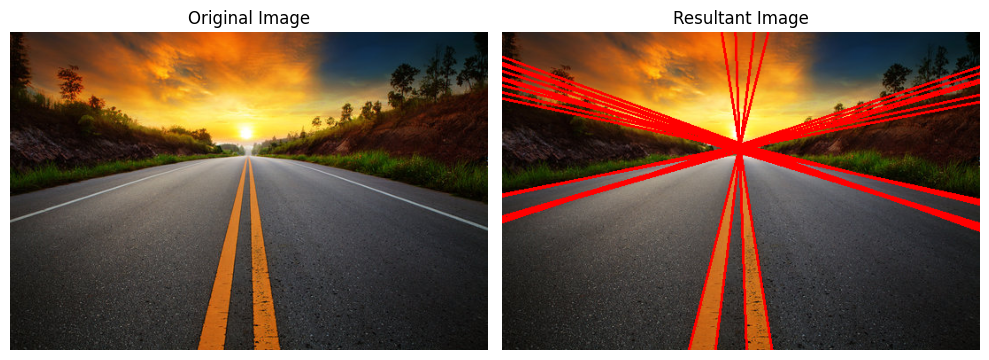

In [8]:
def load_and_preprocess_image(image_path):
    original_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    return original_image, gray_image

def detect_edges(gray_image, low_threshold=200, high_threshold=200):
    return cv2.Canny(gray_image, low_threshold, high_threshold)

def detect_lines(edges, rho=1, theta=np.pi / 180, threshold=100):
    return cv2.HoughLines(edges, rho, theta, threshold)

def draw_lines(image, lines, color=(0, 0, 255), thickness=2):
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

def display_images(original_image, processed_image, titles=('Original Image', 'Resultant Image')):
    plt.figure(figsize=(10, 5))
    images = [original_image, processed_image]
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def detect_and_highlight_lines(image_path):
    original_image, gray_image = load_and_preprocess_image(image_path)
    edges = detect_edges(gray_image)
    lines = detect_lines(edges)
    result_image = draw_lines(original_image.copy(), lines)
    display_images(original_image, result_image)

detect_and_highlight_lines('../images/road.jpg')


In the Hough Transform for line detection, the parameters `ρ`, `θ`, and the vote threshold directly affect the results:

- **Increasing ρ (distance resolution) or θ (angular resolution)**: This reduces sensitivity, resulting in fewer, more distinct lines being detected. Lower resolutions can capture broad features but may miss finer details.

- **Raising the vote threshold**: This filters out weaker lines, focusing only on the strongest candidates. It helps reduce clutter and improves clarity by emphasizing the most prominent features.

In the example, higher thresholds and resolutions produce cleaner outputs by highlighting the most prominent road lines.


## 3. Circle Detection Using Hough Circle Transform

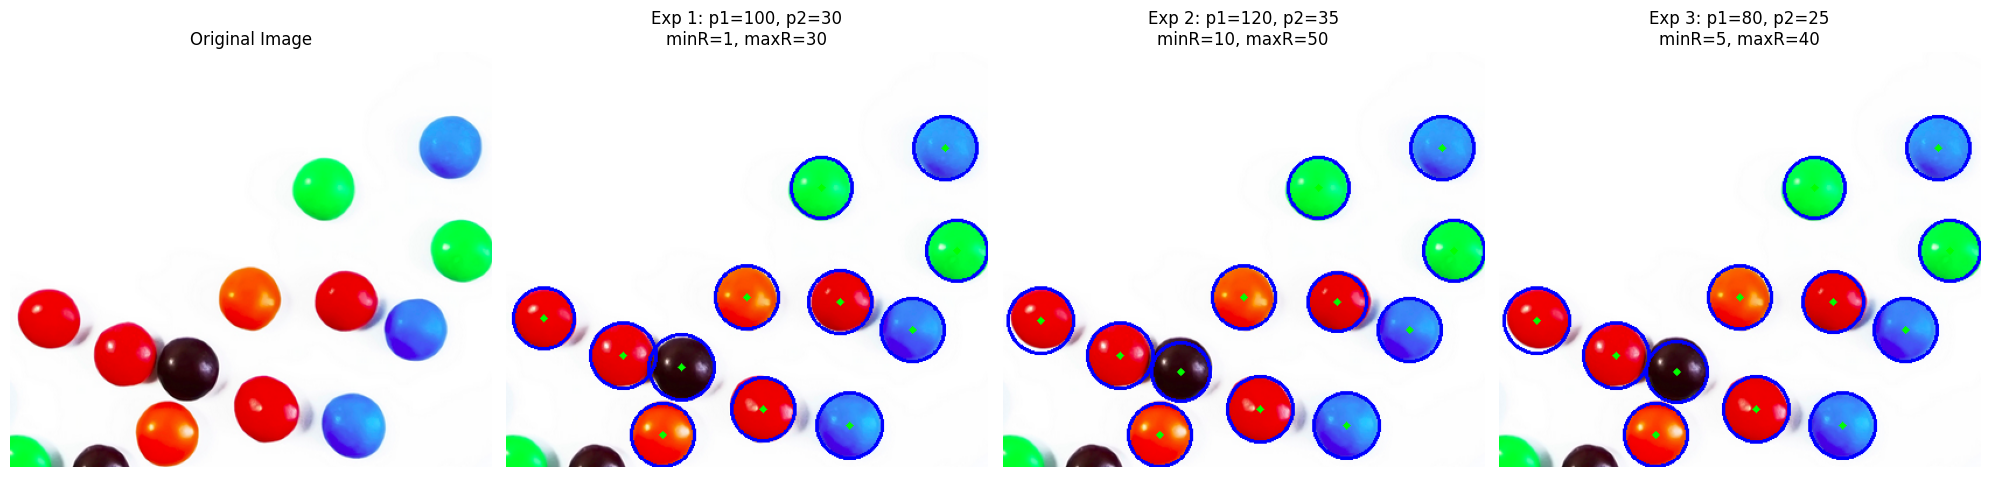

In [9]:

def detect_circles(image, dp=1, min_dist=30, param1=100, param2=30, min_radius=1, max_radius=30):
    return cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp, min_dist,
                            param1=param1, param2=param2,
                            minRadius=min_radius, maxRadius=max_radius)

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)
    return gray

def overlay_circles(image, circles):
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            # Draw circle center
            cv2.circle(image, center, 1, (0, 255, 0), 3)
            # Draw circle outline
            cv2.circle(image, center, radius, (255, 0, 0), 2)

def main():
    filename = '../images/coin-detection.jpg'
    src = cv2.imread(filename, cv2.IMREAD_COLOR)
    if src is None:
        print(f"Error: Unable to load image '{filename}'")
        return

    # Preprocess the image
    gray = preprocess_image(src)

    # Experiment with different radius ranges and accumulator thresholds
    experiments = [
        {"param1": 100, "param2": 30, "min_radius": 1, "max_radius": 30},
        {"param1": 120, "param2": 35, "min_radius": 10, "max_radius": 50},
        {"param1": 80, "param2": 25, "min_radius": 5, "max_radius": 40},
    ]

    # Display results for each experiment
    fig, axs = plt.subplots(1, len(experiments) + 1, figsize=(20, 5))
    axs[0].imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    for idx, params in enumerate(experiments):
        circles = detect_circles(
            gray,
            dp=1,
            min_dist=30,
            param1=params["param1"],
            param2=params["param2"],
            min_radius=params["min_radius"],
            max_radius=params["max_radius"],
        )

        # Copy the source image to draw circles
        src_copy = src.copy()
        overlay_circles(src_copy, circles)
        axs[idx + 1].imshow(cv2.cvtColor(src_copy, cv2.COLOR_BGR2RGB))
        axs[idx + 1].set_title(f"Exp {idx+1}: p1={params['param1']}, p2={params['param2']}\n"
                               f"minR={params['min_radius']}, maxR={params['max_radius']}")
        axs[idx + 1].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


1. **Exp 1** (`param1=100, param2=30, min_radius=1, max_radius=30`):  
   - Sensitive to small circles, but also detects noise.  
   - Effective for detecting low-intensity edges due to lower thresholds.  

2. **Exp 2** (`param1=120, param2=35, min_radius=10, max_radius=50`):  
   - Focuses on larger circles with minimal noise.  
   - Higher thresholds reduce false positives but miss smaller circles.  

3. **Exp 3** (`param1=80, param2=25, min_radius=5, max_radius=40`):  
   - Captures circles across sizes, balancing sensitivity and accuracy.  
   - Can detect both small and large circles but may include some false positives.  

Fine-tuning thresholds and radius ranges helps optimize detection.


## 4. Harris Corner Detection

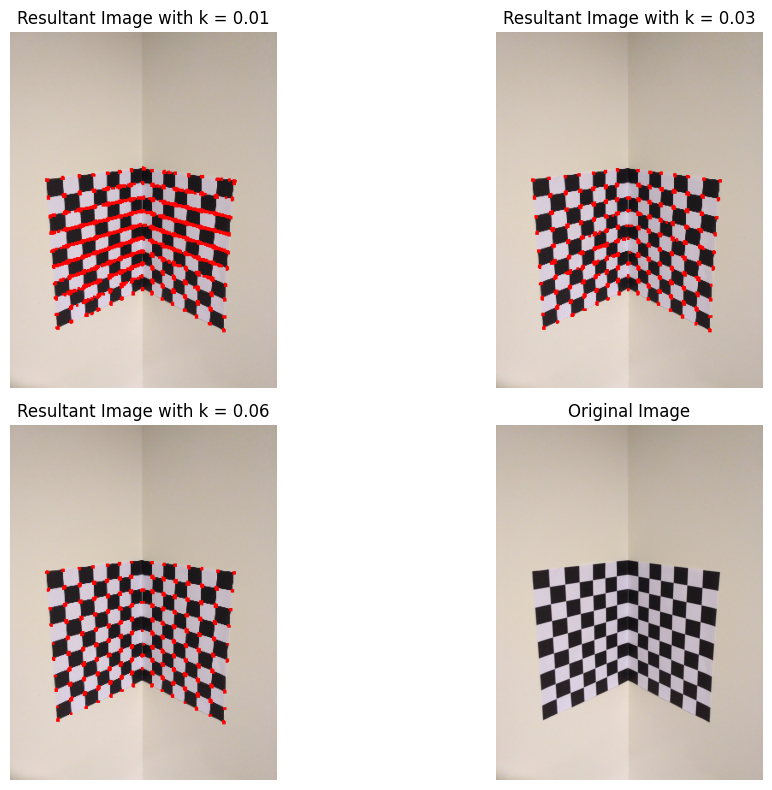

In [10]:


def process_image_with_harris(img, k_value):
    gray = np.float32(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    dst = cv2.cornerHarris(gray, 2, 3, k=k_value)
    dst = cv2.dilate(dst, None)
    img[dst > 0.01 * dst.max()] = [0, 0, 255]
    return img

def Harris_Corners(img_path):
    img = cv2.imread(img_path)
    original_image = img.copy()
    resized_image = cv2.resize(img, (int(img.shape[1] / 10), int(img.shape[0] / 10)))

    result_img_k01 = process_image_with_harris(resized_image.copy(), 0.01)
    result_img_k02 = process_image_with_harris(resized_image.copy(), 0.03)
    result_img_k06 = process_image_with_harris(resized_image.copy(), 0.06)

    plt.figure(figsize=(12, 8))
    images = [result_img_k01, result_img_k02, result_img_k06, original_image]
    titles = [
        'Resultant Image with k = 0.01',
        'Resultant Image with k = 0.03',
        'Resultant Image with k = 0.06',
        'Original Image',
    ]
    
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Harris_Corners('../images/calib-object.jpg')


The sensitivity parameter `k` in the Harris Corner Detection function controls the trade-off between detecting strong corners and avoiding weaker ones. Here's how it works:

- **Higher k values** (e.g., `k = 0.04`): The algorithm becomes more selective, detecting fewer, but stronger corners, and ignoring weaker ones. This helps reduce noise but may miss subtle corner features.

- **Lower k values** (e.g., `k = 0.01`): The algorithm becomes more sensitive and detects a larger number of features, including weaker corners, but this can increase the likelihood of false positives.

Thus, selecting the right value for `k` requires balancing between detecting genuine corners and avoiding excessive sensitivity to non-corner features.


## 5. Short Theory

The Hough Transform is a technique for detecting geometric shapes like lines and circles by converting points from image space into a parameter space. For line detection, each image point (x, y) is mapped to a line in polar coordinates, characterized by parameters (ρ, θ). The intersection of these lines in the parameter space highlights potential lines in the image. Since lines are represented by only two parameters, the process is computationally efficient.

On the other hand, circle detection is more complex. Here, each image point is mapped to a 3D parameter space (a, b, r), where (a, b) denotes the circle's center and r is its radius. This raises the computational demands because the algorithm must identify peaks in a 3D accumulator. Circle detection is computationally heavier and typically requires preprocessing, like smoothing, to reduce noise and improve precision. Additionally, it is more sensitive to variations in the radius parameters, which require careful tuning for optimal performance.